<a href="https://colab.research.google.com/github/praldemir12/PUC_ML_DL/blob/main/MVP_Sprint_II_DL_PUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP Sprint II - Deep Learning: Visão Computacional**

## Aldemir Rodrigues Junior

### MVP classificação de imagens utilizando uma rede neural convolucional (CNN)

# 1 - Definição do Problema

## Reconhecimento de cenas internas

O desafio é criar um modelo de aprendizado profundo que aprenda a reconhecer diferentes tipos de ambientes internos através de imagens. A ideia é, por exemplo, mostrar ao programa uma foto de um fogão em uma cozinha, e ele entenda e diga que é cozinha.

No entanto, fazer isso não é fácil. Cada tipo de ambiente, como uma livraria ou um corredor, tem características muito diferentes. Alguns ambientes são mais facilmente reconhecidos pelas coisas que estão neles (como os livros em uma livraria), enquanto outros são reconhecidos pela maneira como o espaço é organizado (como um corredor).

Estou usando uma ferramenta chamada PyTorch para construir nosso programa. O objetivo é treiná-lo para que, quando olhar para uma nova imagem de um ambiente interno que nunca viu antes, ele possa acertar que tipo de ambiente é esse. Isso é um grande desafio no campo de ensinar computadores a 'verem' e entenderem imagens, e é isso que estou me propondo resolver."

As imagens utilizadas são do MIT - Indoor Scenes, obtidas no seguinte endereço:

fonte: https://www.kaggle.com/datasets/itsahmad/indoor-scenes-cvpr-2019

In [1]:
#Carregar todas as bibliotecas

import os
import torch
import torchvision
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

As bibliotecas acima estão sendo carregadas para este projeto de aprendizado de máquina, aprendizado profundo e processamento de imagens. Torch e torchvision são bibliotecas do PyTorch para aprendizado profundo. Torchvision é uma biblioteca complementar que fornece utilitários para trabalhar com imagens e vídeo, incluindo funções para carregar conjuntos de dados de imagens, realizar transformações de imagens e implementar modelos de visão computacional comuns.
Este projeto de deep learning terá as seguintes etapas: carregar dados, manipulá-los, criar e treinar modelos de redes neurais, avaliar seu desempenho e visualizar os resultados.

https://pytorch.org/   
https://pytorch.org/vision/stable/index.html


In [2]:
#Este comando está removendo (deletando) o diretório "PUC_ML_DL". Garantir que estou trabalhando com a ver~sao mais recente do repositório
!rm -r /content/PUC_ML_DL/

#Clonagem do repositório do GitHub
!git clone https://github.com/praldemir12/PUC_ML_DL.git

repo_dir = "PUC_ML_DL"
path = os.path.join(repo_dir, "imagens")

# Lista para armazenar as imagens
images = []

# Lê todas as imagens no diretório
for filename in os.listdir(path):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Verifica se o arquivo é uma imagem
        img = Image.open(os.path.join(path, filename))
        images.append(img)

rm: cannot remove '/content/PUC_ML_DL/': No such file or directory
Cloning into 'PUC_ML_DL'...
remote: Enumerating objects: 428, done.
remote: Total 428 (delta 0), reused 0 (delta 0), pack-reused 428
Receiving objects: 100% (428/428), 100.50 MiB | 31.96 MiB/s, done.
Resolving deltas: 100% (12/12), done.


O objetivo desta parte é remover um diretório existente, clonar um repositório do GitHub, ler todas as imagens (arquivo .jpg e .png) de um diretório específico e armanzenar essas imagens em uma lista

In [3]:
# Caminho do diretório das imagens no Google Colab
data_dir = "/content/PUC_ML_DL/imagens/"

# Lista para armazenar as imagens
images = []

# Lê todas as imagens no diretório
for filename in os.listdir(data_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):  # Verifica se o arquivo é uma imagem
        img = Image.open(os.path.join(data_dir, filename))
        images.append(img)

# Classes
classes = os.listdir(data_dir)
print(classes)


['bathroom', 'kitchen', 'buffet']


O objetivo deste código é usar as classes escolhidas: kitchen, bathroom, e buffet para treinar um modelo de aprendizagem de máquina.

In [4]:
len(classes)

3

# 2 - Processamento dos dados

Aplicando transformações as imagens, redimensionando para um tamanho de 256x256, em seguinda convertendo em tensores. Esses passos são para preparar imagens para uso em um modelo de aprendizado de máquina pelo pytorch.

In [5]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [6]:
len(dataset)

388

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# funcao para mostra 1 imagem de exemplo
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

#Apresentação de uma imagem (51a. imagem)

Label: bathroom (Class No: 0)


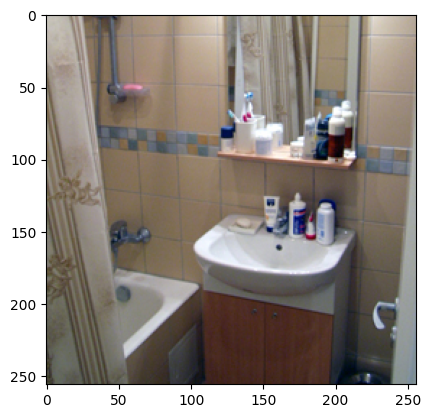

In [8]:
img, label = dataset[50]
show_sample(img, label)

# 3 - Definindo o random seed

Definindo uma semente para o gerador de números aleatórios do PyTorch. Isso garante que vou obter os mesmos resultados cada vez que executar o código. Isso é útil para a reprodutibilidade dos resultados.

In [9]:
random_seed = 42
torch.manual_seed(random_seed)

# 4 - Divisão do dataset

Dividindo o conjunto de dados em três partes: um conjunto de treinamento, um conjunto de validação e um conjunto de teste.
O conjunto de treinamento é usado para treinar o modelo, o conjunto de validação é usado para ajustar os hiperparâmetros e avaliar o desempenho do modelo durante o treinamento, e o conjunto de teste é usado para avaliar o desempenho final do modelo. A divisão aleatória ajuda a garantir que a avaliação do modelo seja justa e que não haja vazamento de informações entre os conjuntos.

In [10]:
train_len = int(len(dataset)*0.7) # 70% dos dados para treinamento
val_len = int(len(dataset)*0.15) # 15% dos dados para validação
test_len = len(dataset) - train_len - val_len # 15% dos dados para teste

train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])

# 5 - Preparação dos DataLoaders

In [11]:
from torch.utils.data.dataloader import DataLoader
batch_size = 25

Preparando para carregar os dados em lotes.
Carregar dados em lotes permite treinar o modelo em subconjuntos menores de dados de uma vez, o que pode ser mais eficiente do que tentar carregar todos os dados de uma vez.

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Configurando como os dados serão carregados para o treinamento e validação do modelo.

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

Função para visualizar como as imagens no DataLoader aparecem. Verificar se as imagens estão sendo carregadas e transformadas corretamente.






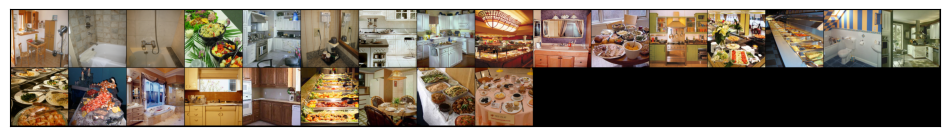

In [14]:
# amostras do lote de treinamento
show_batch(train_dl)

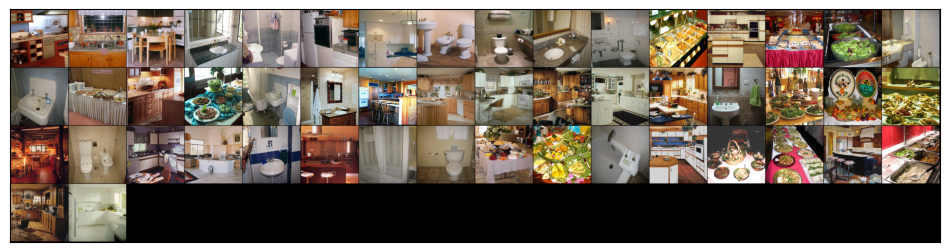

In [15]:
# amostras do lote de validacao
show_batch(val_dl)

# 6 - Definição do pipeline de treino de validação do modelo de classificação de imagens

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

Este bloco de código define uma função de precisão e uma classe base para classificação de imagens usando PyTorch:

1 accuracy(outputs, labels): Esta função calcula a precisão das previsões de um modelo. Ela faz isso comparando as previsões de classe mais prováveis (preds) com os rótulos verdadeiros (labels), contando quantos deles correspondem e dividindo pelo número total de previsões.

2 ImageClassificationBase(nn.Module): Esta é uma classe base para modelos de classificação de imagens. Ela define vários métodos que são comumente usados durante o treinamento e validação de tais modelos:

2.1 training_step(self, batch): Esta função é chamada durante cada passo do treinamento. Ela pega um lote de dados, gera previsões para esse lote, calcula a perda de entropia cruzada das previsões e retorna essa perda.

2.2 validation_step(self, batch): Esta função é similar à training_step, mas é chamada durante a validação. Além de calcular e retornar a perda, ela também calcula e retorna a precisão do modelo no lote de validação.

2.3 validation_epoch_end(self, outputs): Esta função é chamada ao final de cada época de validação. Ela pega as perdas e precisões de todos os lotes de validação da época, calcula a média deles e retorna essas médias.

2.4 epoch_end(self, epoch, result): Esta função é chamada ao final de cada época de treinamento. Ela imprime a perda de treinamento, a perda de validação e a precisão de validação para a época.

Esta classe base pode ser estendida por modelos de classificação de imagens específicos para herdar essas funcionalidades úteis. As funções que definem como calcular a perda e a precisão, e como tratar os resultados ao final de cada passo e época de treinamento e validação são muitas vezes necessárias ao treinar modelos de aprendizado profundo.

In [17]:
transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataset = ImageFolder(data_dir, transform = transformations)

# 7 - Definição do modelo de classificação de imagens

In [18]:
class ResNet(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet(len(dataset.classes))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


Este bloco de código define uma classe ResNet que herda da classe base ImageClassificationBase que foi definida anteriormente.

A classe ResNet utiliza o modelo ResNet pré-treinado, que é um tipo popular de rede neural convolucional, e modifica a última camada para se adaptar ao problema de classificação de imagens em questão.
Em resumo, este bloco de código define e cria um modelo de classificação de imagens usando uma versão modificada do modelo ResNet pré-treinado. Esta é uma estratégia comum em aprendizado de máquina chamada transferência de aprendizado, onde um modelo treinado em um grande conjunto de dados é usado e então ajustado para um problema específico. Isso pode levar a um treinamento mais rápido e melhores performances, especialmente quando o conjunto de dados do problema específico é relativamente pequeno.

HE, Kaiming et al. Deep residual learning for image recognition. In: Proceedings of the IEEE conference on computer vision and pattern recognition. 2016. p. 770-778.


# 8 - Movendo os dados e o modelo para o dispositivo correto (GPU ou CPU)

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Este bloco de código define várias funções e uma classe para trabalhar com dispositivos em PyTorch.
Em resumo, essas funções e a classe permitem que se escreva código que pode usar a GPU quando disponível, e que automaticamente move dados para a GPU antes do treinamento ou da inferência. Isso pode acelerar significativamente o treinamento de modelos de aprendizado profundo.

In [20]:
device = get_default_device()
device

device(type='cpu')

In [21]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Neste bloco de código está sendo definido o dispositivo a ser usado para o treinamento e a inferência do modelo. A primeira linha define o dispositivo para a CPU, que é a opção padrão se uma GPU não estiver disponível.

Em seguida, as instâncias de DeviceDataLoader são criadas para os dataloaders de treinamento e validação. O DeviceDataLoader é um wrapper para um dataloader PyTorch normal que automaticamente move os dados para o dispositivo especificado antes de cada iteração. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Finalmente, a função to_device() é usada para mover o modelo para o dispositivo especificado. Isso é necessário porque, para treinar o modelo na GPU, tanto os dados quanto o modelo devem estar na GPU.

Este é um exemplo de como PyTorch permite o controle detalhado sobre onde os cálculos são realizados, o que pode ser importante para obter o melhor desempenho ao treinar modelos de aprendizado profundo.

https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel



# 9 - Funções de treino e avaliação do modelo

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Este código define duas funções para treinar e avaliar um modelo de aprendizado profundo.

1)evaluate(model, val_loader): Esta função é usada para avaliar o desempenho do modelo em um conjunto de dados de validação. O modelo é colocado no modo de avaliação (isso desativa coisas como dropout e normalização de batch que se comportam de maneira diferente durante o treinamento). Em seguida, ele itera sobre o dataloader de validação, executando a etapa de validação definida na classe do modelo para cada lote e armazenando os resultados. No final, ele chama a função validation_epoch_end para combinar os resultados de todos os lotes em uma única métrica de perda e acurácia para a época de validação.

2)fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD): Esta função é usada para treinar o modelo. Ele recebe o número de épocas para treinar, a taxa de aprendizado, o modelo a ser treinado, os dataloaders de treinamento e validação e a função do otimizador a ser usada (o SGD é o padrão).

In [23]:
model = to_device(ResNet(len(dataset.classes)), device)

In [24]:
evaluate(model, val_dl)

{'val_loss': 1.1298816204071045, 'val_acc': 0.20499999821186066}

Esses resultados mostram o desempenho inicial do modelo antes do treinamento. O objetivo do treinamento será minimizar a perda (val_loss) e maximizar a precisão (val_acc).

# 10 - Treinamento do modelo

In [25]:
# numero de epocas de treino
num_epochs = 10
# otimizador ADAM
opt_func = torch.optim.Adam
# learning reate
lr = 6e-5

# treino do modelo
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 0.9601, val_loss: 0.7804, val_acc: 0.9175
Epoch 2: train_loss: 0.7160, val_loss: 0.6662, val_acc: 0.9275
Epoch 3: train_loss: 0.6404, val_loss: 0.6445, val_acc: 0.9275
Epoch 4: train_loss: 0.6085, val_loss: 0.6386, val_acc: 0.9275
Epoch 5: train_loss: 0.5834, val_loss: 0.6360, val_acc: 0.9275
Epoch 6: train_loss: 0.5731, val_loss: 0.6345, val_acc: 0.9275
Epoch 7: train_loss: 0.5681, val_loss: 0.6320, val_acc: 0.9375
Epoch 8: train_loss: 0.5641, val_loss: 0.6303, val_acc: 0.9275
Epoch 9: train_loss: 0.5721, val_loss: 0.6274, val_acc: 0.9375
Epoch 10: train_loss: 0.5619, val_loss: 0.6278, val_acc: 0.9375


Este bloco de código está definindo os hiperparâmetros para o treinamento do modelo e, em seguida, chamando a função fit para realizar o treinamento.
Os resultados mostram a perda de treinamento (train_loss), a perda de validação (val_loss) e a acurácia de validação (val_acc) para cada época durante o treinamento.
A acurácia de validação está aumentando ao longo do tempo, alcançando 93,75% na última época. Isso sugere que o modelo está classificando corretamente cerca de 94% das imagens no conjunto de validação, que é um bom resultado.

# 11 - Avaliação do desempenho do modelo

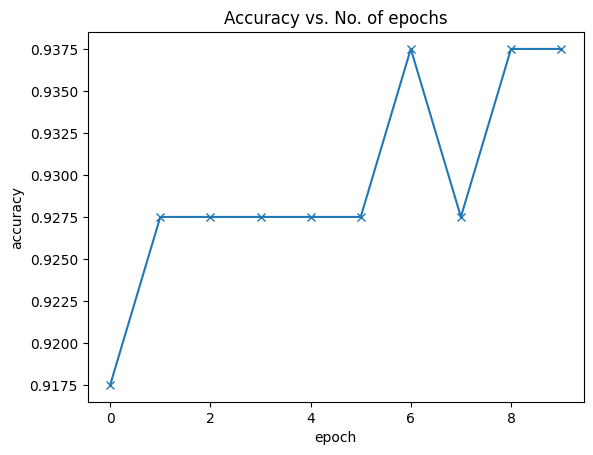

In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

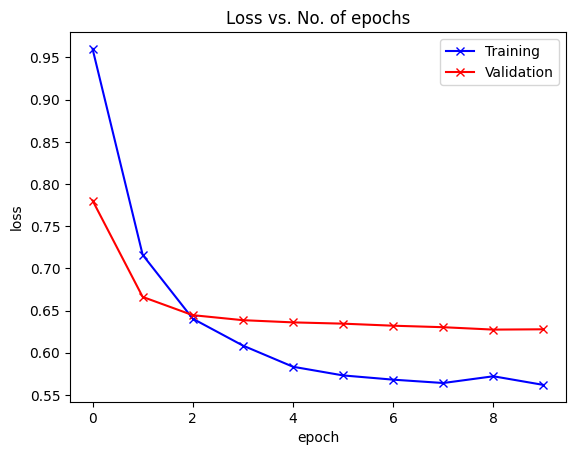

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [28]:
evaluate(model, val_dl)

{'val_loss': 0.6277938485145569, 'val_acc': 0.9375}

Este resultado está indicando a performance modelo na validação do conjunto de dados após o treinamento.
A acurácia é bastante alta e a perda é relativamente baixa, isso sugere que o seu modelo está performando bem no conjunto de validação.

# 12 - Predição em uma única imagem

Fazendo previsões em uma única imagem com o modelo treinado.

In [29]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: buffet , Predicted: buffet


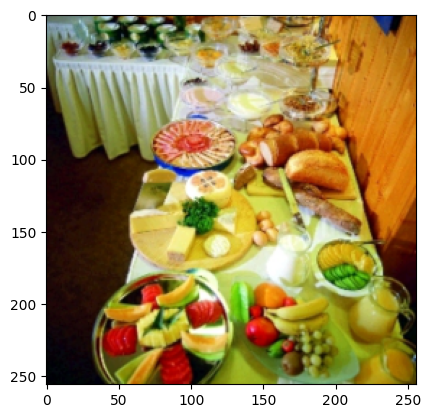

In [30]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

No resultado apresentado, Label: buffet, Predicted: buffet indica que a classe verdadeira da imagem é 'buffet' e o modelo também previu corretamente a classe como 'buffet'.

Label: kitchen , Predicted: kitchen


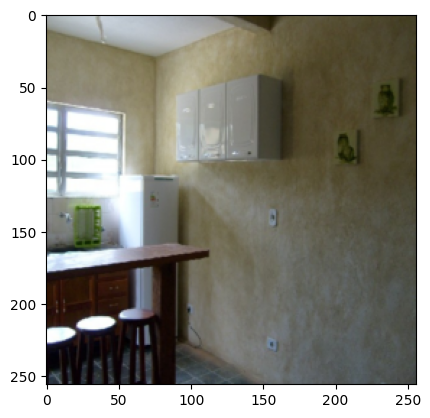

In [31]:
img, label = test_ds[22]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

No segundo caso o resultado apresentado, Label: kitchen, Predicted: kitchen indica que a classe verdadeira da imagem é 'kitchen' e o modelo também previu corretamente a classe como 'kitchen'.

# 13 - Avaliando o modelo atravez da matriz de confusão

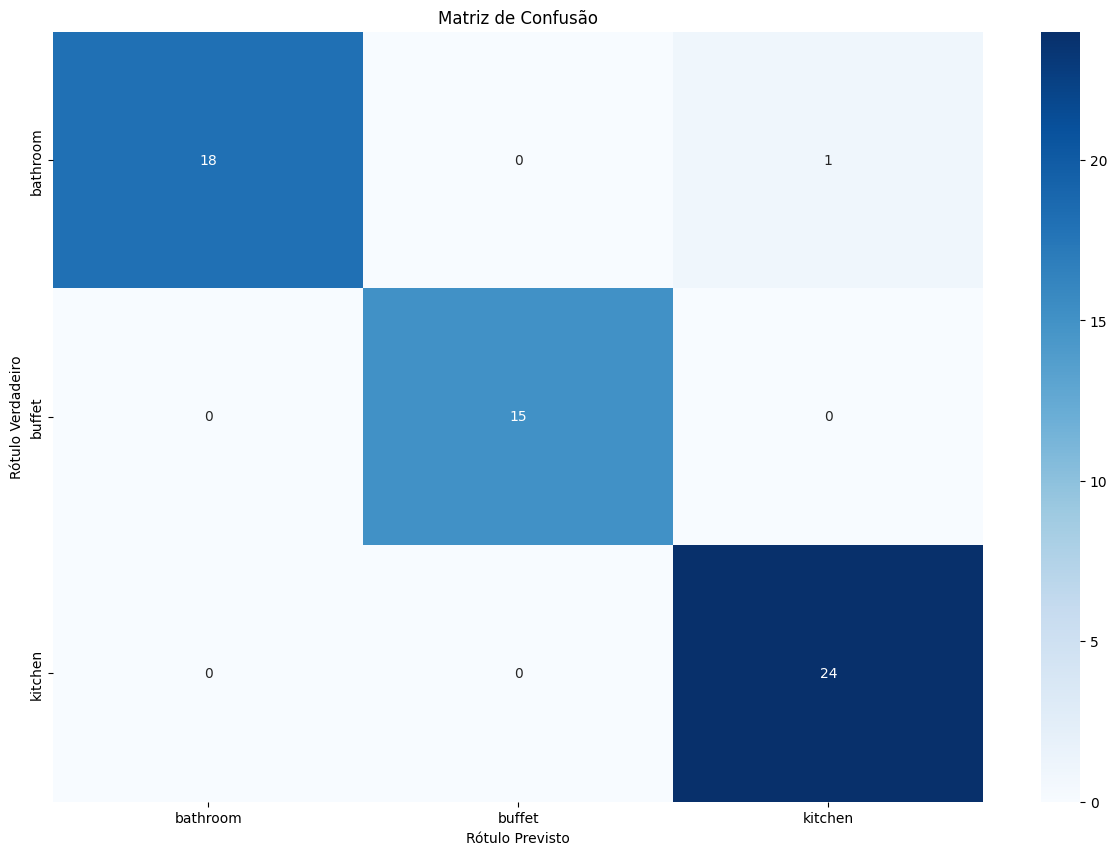

In [32]:
# Coloque o modelo em modo de avaliação
model.eval()

# Listas para armazenar os rótulos verdadeiros e previstos
true_labels = []
predicted_labels = []

# Percorra todos os lotes no conjunto de dados
for images, labels in val_dl:
    # Mova os dados para o dispositivo correto
    images = to_device(images, device)
    labels = to_device(labels, device)

    # Calcule as saídas do modelo
    outputs = model(images)

    # Obtenha os rótulos previstos
    _, preds = torch.max(outputs, dim=1)

    # Adicione os rótulos verdadeiros e previstos às listas
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(preds.cpu().numpy())

# Calcule a matriz de confusão
cm = confusion_matrix(true_labels, predicted_labels)

# Plote a matriz de confusão
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Matriz de Confusão')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.show()


Esse código avalia o desempenho do modelo de classificação de imagens no conjunto de validação, usando uma matriz de confusão para ilustrar as previsões corretas e incorretas.
A matriz de confusão representa o desempenho do modelo de classificação de imagens. A matriz de confusão é uma tabela 3x3, pois tem três classes diferentes em seu conjunto de dados.

O primeiro conjunto de quadros (linha 1): Dos objetos que pertencem à classe 1, o modelo previu corretamente 18 como classe 1 (verdadeiro positivo), 0 como classe 2 (falso negativo) e 1 como classe 3 (falso negativo).

O segundo conjunto de quadros (linha 2): Dos objetos que pertencem à classe 2, o modelo previu corretamente 15 como classe 2 (verdadeiro positivo) e não fez previsões incorretas para as classes 1 e 3 (o que significa que não houve falso positivo nem falso negativo para essa classe).

Terceiro conjunto de quadros (linha 3): Dos objetos que pertencem à classe 3, o modelo previu corretamente 24 como classe 3 (verdadeiro positivo) e não fez previsões incorretas para as classes 1 e 2 (o que significa que não houve falso positivo nem falso negativo para essa classe).

Em resumo, o modelo parece estar desempenhando muito bem. A maioria das previsões corresponde ao rótulo verdadeiro. No entanto, houve uma instância em que o modelo previu a classe 3, mas o rótulo verdadeiro era a classe 1. Esse tipo de análise pode te ajudar a entender onde o modelo está tendo um bom desempenho e onde ele está cometendo erros.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

#Conclusão:
O projeto realizou a classificação de imagens utilizando uma rede neural convolucional (CNN) baseada no modelo ResNet18 pré-treinado, com o objetivo de categorizar imagens em três classes distintas.

Inicialmente, as imagens foram carregadas e processadas em lotes adequados para treinamento, validação e teste. Em seguida, foi aplicado o modelo ResNet18, que foi adaptado para classificar as imagens em suas respectivas classes.

Durante o processo de treinamento, o modelo foi avaliado em cada época para monitorar o desempenho nos conjuntos de treinamento e validação, e ajustar os parâmetros do modelo de acordo.

Ao final do treinamento, o desempenho do modelo melhorou consideravelmente. A acurácia final no conjunto de validação foi de aproximadamente 93,75%. Isso sugere que o modelo aprendeu representações eficazes das imagens e foi capaz de classificar imagens novas com alta precisão.

Adicionalmente, a matriz de confusão revelou que o modelo estava fazendo previsões precisas na maioria dos casos, com apenas uma pequena quantidade de erros.

Em resumo, este projeto demonstrou com sucesso como uma rede neural convolucional pré-treinada pode ser aplicada para a tarefa de classificação de imagens com resultados promissores. No entanto, um passo adicional seria testar o modelo em um conjunto de dados de teste independente para validar ainda mais a generalização do modelo para dados não vistos. Adicionalmente, o modelo poderia ser potencialmente melhorado através de técnicas como aumento de dados, otimização de hiperparâmetros ou treinamento por mais épocas.